In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/proyectos3/
!ls

/content/drive/MyDrive/proyectos3
alexNet.ipynb	    evaluation	      GoogleNet.ipynb  PlantVillage_bgremoved  wandb
cnn.ipynb	    evaluation.ipynb  models	       potato_uncontrolled
efficientNet.ipynb  fusion_plant      PlantDoc	       resNet.ipynb


In [3]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [5]:
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [6]:
import torch.nn as nn
class EfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = torch.hub.load('rwightman/gen-efficientnet-pytorch', 'efficientnet_b0', pretrained=True)
        self.network.classifier = nn.Linear(self.network.classifier.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_predictions(model, loader):
    all_preds = []
    all_targets = []
    for batch in loader:
        images, targets = batch

        preds = model(images)
        all_preds.extend(preds.argmax(dim=-1).cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    return all_preds, all_targets


In [4]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
data_test_dir = './fusion_plant/test'
dataset_test = ImageFolder(data_test_dir, test_transform)
data_loader_test = DataLoader(dataset_test)

In [27]:
device = get_default_device()
model = EfficientNet(3)
model = to_device(model, device)
model.load_state_dict(torch.load('./models/plant_disease_aug_efficientNet1_100.pth'))

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


<All keys matched successfully>

In [28]:
test_loader = DeviceDataLoader(data_loader_test, device)

In [29]:
import torch.nn.functional as F
from sklearn.metrics import precision_score, f1_score

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def validate_step(model, batch):
    images, labels = batch
    out = model(images)
    loss = F.cross_entropy(out, labels) # loss
    preds = torch.argmax(out, dim=1)
    acc = accuracy(out, labels) # accuracy

    # precision and f1 score
    prec = precision_score(labels.cpu(), preds.cpu(), average='macro')
    f1 = f1_score(labels.cpu(), preds.cpu(), average='macro')

    return {'val_loss': loss.detach(), 'val_acc': acc, 'val_precision': prec, 'val_f1': f1}

def evaluate(model, val_loader):
    outputs = [validate_step(model, batch) for batch in val_loader]
    val_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(val_losses).mean()       # Combine loss
    val_accuracies = [x["val_acc"] for x in outputs]
    epoch_accuracy = torch.stack(val_accuracies).mean()
    val_precisions = [x["val_precision"] for x in outputs]
    epoch_precision = torch.tensor(sum(val_precisions)/len(val_precisions))
    val_f1s = [x["val_f1"] for x in outputs]
    epoch_f1 = torch.tensor(sum(val_f1s)/len(val_f1s))
    return {'val_loss': epoch_loss.item(), 'val_accuracy': epoch_accuracy.item(), 'val_precision': epoch_precision.item(), 'val_f1': epoch_f1.item()}

evaluate(model, test_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

{'val_loss': 1.88527250289917,
 'val_accuracy': 0.35777777433395386,
 'val_precision': 0.35777777777777775,
 'val_f1': 0.35777777777777775}

<Axes: >

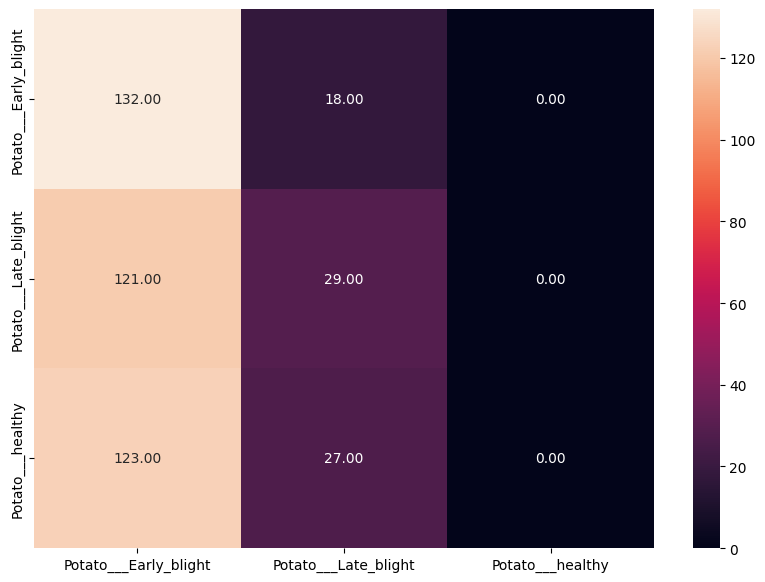

In [31]:
all_preds, all_targets = get_predictions(model, test_loader)

class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

cm = confusion_matrix(all_targets, all_preds)

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f')